In [14]:
import numpy as np
from sklearn.cluster import KMeans as sk_kmeans
from sklearn.cluster import AgglomerativeClustering as HArchClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from sklearn import metrics, datasets

In [2]:
# Generate 3D swiss roll data for showcase visualization
swissX, swiss_labels = datasets.make_swiss_roll(n_samples=1000)


# The three datasets that I've chosen

# Dataset 1: 
# A dataset about observed features of pulsar stars
# Source: http://archive.ics.uci.edu/ml/datasets/HTRU2
# As a reference citing to the The HTRU2 dataset, it was created by and used for:
# R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar
# Candidate Selection: From simple filters to a new principled real-time classification approach
# MNRAS, 2016.
# The HTRU2 dataset contains 8 features and a label for each observation.
pulsarData = np.genfromtxt("HTRU_2.csv", delimiter=",", max_rows = 1000)
pulsarX, pulsarY = pulsarData[:,:7] , pulsarData[:,8]

# Dataset 2:
# A dataset about distinguishing between nasal and oral sounds
# Source: https://www.openml.org/search?type=data&sort=runs&status=active&id=1489
# Author (according to the openml page): Dominique Van Cappel, THOMSON-SINTRA
# Contains 5 features and a label, skipping the 10 first rows as they contain description of the features. 
# Also, skip_header cannot be used together with max_rows as per the numpy documentation.
soundsData = np.genfromtxt("php8Mz7BG.arff", delimiter=",", skip_header=10, max_rows=1000)
soundsX, soundsY = soundsData[:,:5], soundsData[:,5]

# Dataset 3:
# Taken from a previous assignment (assignment 2, exercise logistic multivariate regression), banknote-authentication
# Contains 4 features and a label.
bankData = np.genfromtxt("banknote_authentication.csv", delimiter=",", max_rows = 1000)
bankX, bankY = bankData[:,:4], bankData[:,4]

In [84]:
def sammon(X, iter, err_threshold, alpha):
    lowerBound = 1e-5 # The replacement lowerbound value to avoid division by 0 or very close to 0
    
    # The random starting points for Y
    Y = np.random.normal(0.0, 1.0, [len(X), 2])
    
    # The distances in the input space
    inDistances = metrics.pairwise_distances(X,metric='euclidean')
    
    # Creating a nx1 grid of the values from 0 to length of X (to use as indices for i and j) 
    indicesGrid = np.mgrid[0:len(X)]
    
    # Initializing the constant c as: sum of all input distances where the index i is less than index j
    c = np.sum([np.sum(inDistances[i,[np.where(i < indicesGrid)]]) for i in indicesGrid]) 

    for n in range(iter):        
        outDistances = metrics.pairwise_distances(Y,metric='euclidean')
        
        # Calculate stress on each even iteration (as to decrease the computation slightly)
        if n % 2 == 0:
            E = 0
            for i in indicesGrid:
                
                # List of indexes where j was larger than i
                j = np.where(i < indicesGrid)
                
                # The distances in the input and output space
                deltainDistances = inDistances[i,j]
                deltaoutDistances = outDistances[i,j]
                
                # Find the indices where the distance is lower than a certain threshold
                # This is used as to not use division with a value very close to zero
                unsafeIndices = np.where(deltainDistances < lowerBound)
                
                if len(unsafeIndices[1]) > 0:
                    divinDistances = np.copy(deltainDistances)
                    divinDistances[unsafeIndices[0],unsafeIndices[1]] = lowerBound
                    
                    E += np.sum(((deltaoutDistances-deltainDistances)**2) / (divinDistances))
                else:
                    E += np.sum(((deltaoutDistances-deltainDistances)**2) / deltainDistances)

            E = E / c
            
            if E < err_threshold:
                print("Err Threshold reached, returning")
                return Y
        
        # Go through each of the distances in the input and output space
        # calculate the partial derivatives and move the output space dots each iteration
        for i in indicesGrid:    
            # As I replace values lower than the predetermined lowerbound value (as to not divide by 0), keep the original matrix as backup
            backupOutdistances = np.copy(deltaoutDistances) 
            
            # List of indexes where j was larger than i
            j = np.where(i != indicesGrid)
            deltainDistances = inDistances[i,j]
            deltaoutDistances = outDistances[i,j]

            distDivide = deltaoutDistances * deltainDistances

            unsafeIndices_distDivide = np.where(distDivide < lowerBound)
            unsafeIndices_outDistances = np.where(deltaoutDistances < lowerBound)
            
        
             
            # As to decrease the number of iterations (as to not iterate over each j for instance)
            # I want to calculate Yi(t+1) by using as much vectorization as I can. As such I took inspiration from my
            # assignment 1 kNN solution, where I repeat each row in the current Yi (which is one row) until it is the size
            # of the Y[j] matrix (which is all other rows that are not i).
            Yir = np.tile(Y[i], (np.shape(Y[j])[0],1))
            
            
            # Find the indices where the value is close to zero and replace it with the lowerbound
            if len(unsafeIndices_distDivide[1]) > 0:

                distDivide[unsafeIndices_distDivide[0],unsafeIndices_distDivide[1]] = lowerBound
                
            if len(unsafeIndices_outDistances[1]) > 0:

                deltaoutDistances[unsafeIndices_outDistances[0], unsafeIndices_outDistances[1]] = lowerBound

                

            YiYj = (Yir - Y[j])
            
            #               [ inD - outD ]
            #         sum   [------------] * (Yi - Yj)
            #       (i=/=j) [  inD*outD ]
            pd1 = np.dot((np.divide((deltainDistances - deltaoutDistances), distDivide)), YiYj)

            
            # Calculating the 'parts' in the second partial derivative, had to divide up the formula due to its length
            # 
            pd2_1 = np.divide((YiYj**2), deltaoutDistances.reshape(-1,1))
            pd2_2 = (1 + ((deltainDistances - deltaoutDistances) / deltaoutDistances))
            pd2_4 = ((deltainDistances - deltaoutDistances).reshape(-1,1) - (pd2_1 * pd2_2.reshape(-1,1)))
     
            
            pd2 = np.divide(pd2_4 , distDivide.reshape(-1,1)).sum(axis=0)
            
            pderivatives = np.divide((-2/c) * pd1, np.abs((-2/c)*pd2))
            Y[i] = Y[i] - alpha * pderivatives
            
            # If replacement of values occured, return back to unedited state
            deltaoutDistances = backupOutdistances

    print("Iterations exceeded, returning")
    return Y


In [62]:
# Apply sammon mapping on the 3D swiss roll data
swissY = sammon(swissX, 200, 3e-2, 0.5)

Iterations exceeded, returning


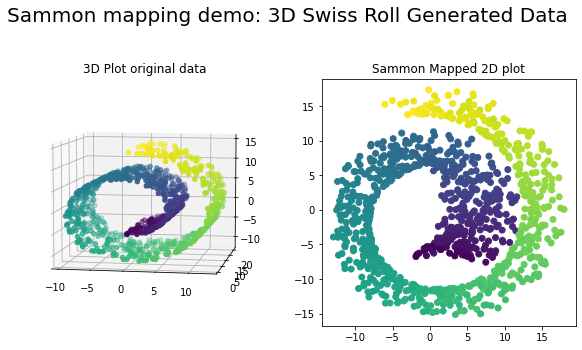

In [63]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sammon mapping demo: 3D Swiss Roll Generated Data", size=20)

swiss_ax_3d = fig.add_subplot(221,projection="3d", elev=7, azim=-80)
swiss_ax_3d.set_title("3D Plot original data")
swiss_ax_3d.scatter(swissX[:,0], swissX[:,1], swissX[:,2], c=swiss_labels, s=20)
    
swiss_ax_2d = fig.add_subplot(222)
swiss_ax_2d.set_title("Sammon Mapped 2D plot")
swiss_ax_2d.scatter(swissY[:,0], swissY[:,1], c=swiss_labels)
    
plt.show()

Iterations exceeded, returning


c:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'TSNE')

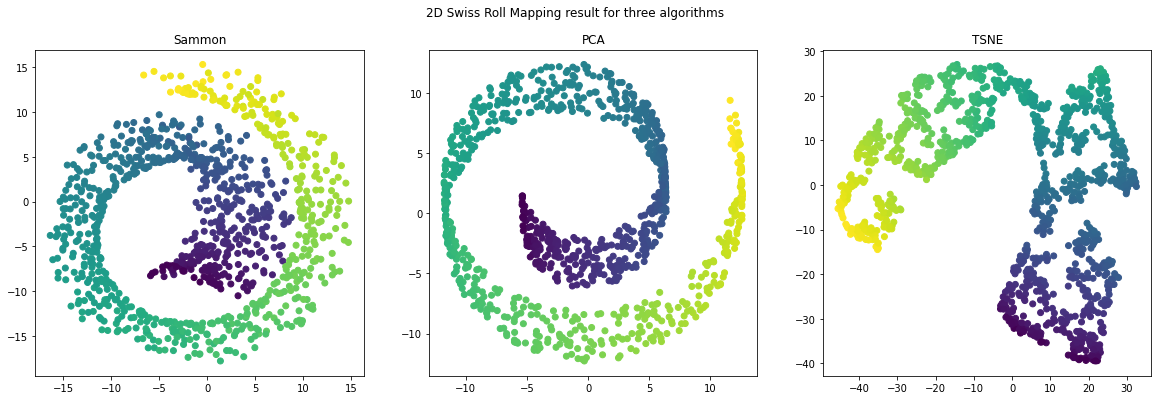

In [83]:
# Swiss Roll Comparison between Sammon, PCA, TSNE
swiss_sammonResult = sammon(swissX, 100, 5e-2, 0.4)
swiss_PCAResult    = PCA(n_components=2).fit_transform(swissX)
swiss_TSNEResult   = TSNE(n_components=2).fit_transform(swissX) 
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle("2D Swiss Roll Mapping result for three algorithms")
axes[0].scatter(swiss_sammonResult[:,0], swiss_sammonResult[:,1], c=swiss_labels)
axes[0].set_title("Sammon")
axes[1].scatter(swiss_PCAResult[:,0], swiss_PCAResult[:,1],   c=swiss_labels)
axes[1].set_title("PCA")
axes[2].scatter(swiss_TSNEResult[:,0], swiss_TSNEResult[:,1], c=swiss_labels)
axes[2].set_title("TSNE")

If my sammon implementation is behaving correctly and the output is reasonable, these results displayed above are very interesting. By using what I can see from these results I can gather that sammon and PCA are more similar in their behaviour than TSNE. The difference between sammon and PCA seems to be that sammon tries to include more points visually in the 2D mapping. As the PCA 2D mapping keeps the design/structure of the swiss roll 3D model (as evident with the smaller radius and twists). However, I would say that sammon in this case displays more information from the data, however the formation is not as detailed as PCA. The TSNE output, which amusingly gives off the look of a split half of a carwheel or a gate, displays the data significantly differently to the other two algorithms. 

The best performing here can personally be difficult to state, mostly due to what one states to be the important factor in this case. In my opinion, due to the fact that I wanted to be able to display the swiss roll data in a 2D space, the important factor was the that the structure of the data was represented. With this I mean that with the swiss roll, I'd be able to visualize it by looking at it at an angle where it became 2D. However, doing in such a manner would not be able to be represent as much data (as they would be blocked by other points, similarl to taking a slice of the roll). 

If one views the output of the sammon mapping to be "compressing the swiss roll in the z-direction", kind of like putting the swiss roll on its side and pressing it flat. Then the output being 'thicker' than the PCA output would, in these simpler terms make sense. Thus it can display more clearly each observation (excluding the information lost when going to a lower dimension).

I will state that for the swiss roll data, I deem the best performing algorithm to be sammon mapping.

A thing I'd like to note is that I observed that the initial random Y-points initialization siginficantly changed the output of the my sammons mapping implementation. I knew that it would impact the output, however I was suprised to see that it could also lead to an inverted end-result. Where the swiss roll was either upside-down, or mirrored. 

### Using the three Dimension Reduction algorithms on the three datasets

Err Threshold reached, returning


c:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Iterations exceeded, returning


c:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Iterations exceeded, returning


c:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


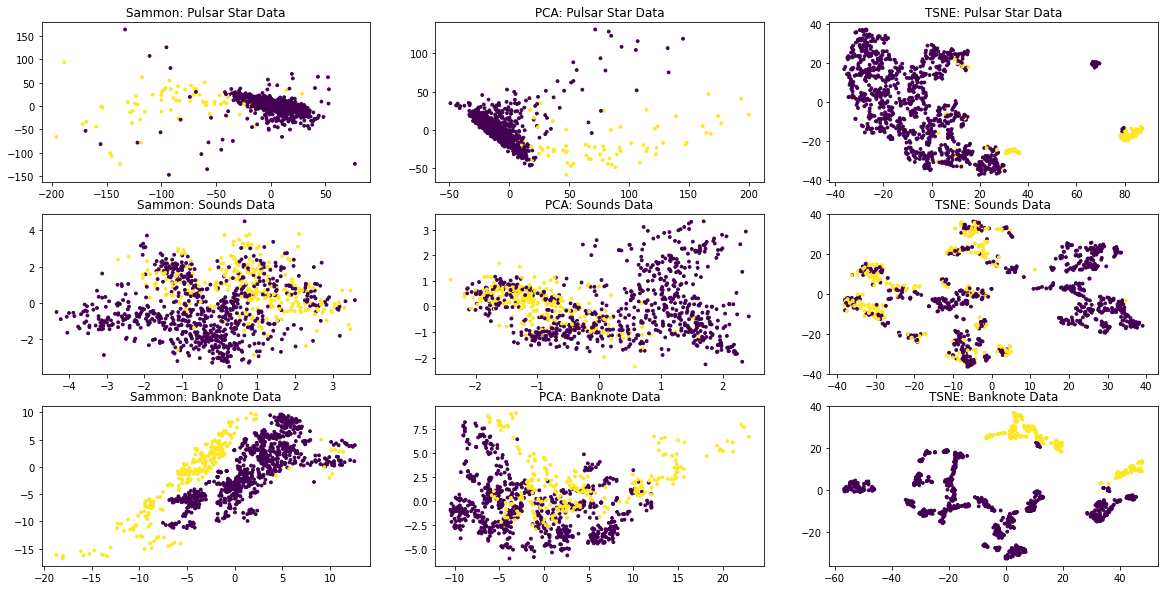

In [96]:
datasetLst, datasetIndx = [[pulsarX,pulsarY], [soundsX,soundsY], [bankX,bankY]], 0
nameLst = ["Pulsar Star Data", "Sounds Data", "Banknote Data"]
fig, axes = plt.subplots(3, 3, figsize=(20,10))

for row in axes:
#     print(row)
    sammonResult = sammon(datasetLst[datasetIndx][0], 100, 3e-2, 0.4)
    PCAResult    = PCA(n_components=2).fit_transform(datasetLst[datasetIndx][0])
    

    TSNEResult   = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(datasetLst[datasetIndx][0])
    
    row[0].scatter(sammonResult[:,0], sammonResult[:,1], c=datasetLst[datasetIndx][1], s=8)
    row[0].set_title("Sammon: " + nameLst[datasetIndx])
    row[1].scatter(PCAResult[:,0], PCAResult[:,1],   c=datasetLst[datasetIndx][1], s=8)
    row[1].set_title("PCA: " + nameLst[datasetIndx])
    row[2].scatter(TSNEResult[:,0], TSNEResult[:,1], c=datasetLst[datasetIndx][1], s=8)
    row[2].set_title("TSNE: "+ nameLst[datasetIndx])
    datasetIndx += 1

plt.show()

I think that I should've probably chosen datasets with more than 2 classes for the labels as the outputs above are a slightly more difficult to view as clearly. Due to time constraints I am not able to change them at this time. The ones I chose were not the most suited for this purpose

Despite the plot results showing what looks like exploding gradients for sammon and PCA (pulsar dataset and banknote). It seems that the original data has them (I had to check using scatter plots of combinations of 2 vectors in X).

From the results above I can see that the results classes from the three algorithms seem to be overlapping in the plots. The T-SNE plot seems more separated moslty due to the structure of the data being changed into what could be almost mistaken for clusters. As there's a clear difference between the purple and yellow dots. The difference between sammon and PCA is not as clear as with T-SNE to the others. However, I do deem the output of sammon mapping to be more separated than PCA. For instance, it separated the banknote classes better than PCA, the latter of which output as nice buttefly plot. 

Due to the fact that I only had 2 classes (0 and 1 as the labels) in each dataset, the question regarding which class was most difficult to separate is simply the 0 classes. This is also due to an overrepresentation of observations that has the label '0' in both datasets. 

I think that I can answer that the best performing technique overall on these datasets were T-SNE. It seperated the classes clearly in all three tests, the closest separation result by another technique was sammon on the banknote dataset. In all the other datasets, T-SNE was significantly more clear in the separation of the two classes. Such as for the Pulsar dataset it had the best separation of the 2 classes by the separation of the large amount observations that had the 0-label, into a large cluster of the 0-class and the latter class in another small cluster. However it seems to not preserve the distances for the observations.



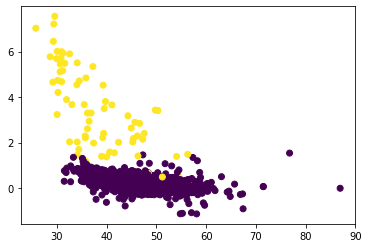

In [93]:
# Displaying two pulsar data vectors, to showcase that the points that are flying off into the distance are part of the dataset
plt.scatter(pulsarX[:,1], pulsarX[:,2], c=pulsarY)